In [46]:
from quchem.Hamiltonian_Generator_Functions import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end


## Circuit Approach

In [66]:
from quchem.Ansatz_Generator_Functions import *

ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)



Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ops_ia,
                                                                                                                Sec_Quant_CC_ops_ijab,
                                                                                                                transformation='JW')

input_state = ansatz_obj.Get_JW_HF_state_in_OCC_basis()
print(input_state)

[1, 1, 0, 0]


In [48]:

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(input_state,
                                     Qubit_Op_list_Second_Quant_CC_Ops_ia, 
                                     Qubit_Op_list_Second_Quant_CC_Ops_ijab)

UCCSD_ansatz_Q_Circ =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_parameters_ia, 
                                         Theta_param_list_ijab=theta_parameters_ijab,
                                         ia_first=True)
UCCSD_ansatz_Q_Circ

0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │
2: ───I───H──────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───────────────
                                                                                                                   │               │                           │              │                                      │               │                                                 │              │                                                  │              │                                          │             

# Lin alg Approach

In [49]:
lin_alg = Ansatz_lin_alg(Hamilt.molecule.n_qubits)

print(input_state)
HF_ket = lin_alg.Get_reference_ket(input_state)
print(HF_ket)

[1, 1, 0, 0]
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [50]:
# UCC_ia_operator = lin_alg.Get_ijab_UCC_matrix_NO_TROT(theta_parameters_ia, UCCSD_ops_ijab)
UCC_ia_operator = lin_alg.Get_ia_UCC_matrix_WITH_trot_SINGLE_STEP(theta_parameters_ia, Qubit_Op_list_Second_Quant_CC_Ops_ia)

In [51]:
# UCC_ijab_operator = lin_alg.Get_ia_UCC_matrix_NO_TROT(theta_parameters_ijab, Qubit_Op_list_Second_Quant_CC_Ops_ijab)
UCC_ijab_operator = lin_alg.Get_ijab_UCC_matrix_WITH_trot_SINGLE_STEP(theta_parameters_ijab, Qubit_Op_list_Second_Quant_CC_Ops_ijab)

In [52]:
Qubit_H_matrix = lin_alg.Get_Qubit_Hamiltonian_matrix(QubitHamiltonian)

In [53]:
ket_post_single_excitation = UCC_ia_operator.dot(HF_ket)
ket_post_double_excitation = UCC_ijab_operator.dot(ket_post_single_excitation)
energy = lin_alg.Calc_energy_of_state(ket_post_double_excitation, Qubit_H_matrix)
print(energy)

(0.004005949846893148+0j)


In [54]:
pauliDict={'X':np.array([[0,1],[1,0]]),
          'Y':np.array([[0,-1j],[1j,0]]),
          'Z':np.array([[1,0],[0,-1]]),
          'I': np.eye(2)}

list_of_ops = [pauliDict[term[0]] for term in 'X0 X1 I2 I3'.split(' ')]
HF_maker_matrix = reduce(np.kron, list_of_ops)

In [55]:
full_matrix_lin_alg = np.matmul(np.matmul(HF_maker_matrix, UCC_ia_operator), UCC_ijab_operator)

# checking equivalence of matrices

In [56]:
np.allclose(full_matrix_lin_alg, UCCSD_ansatz_Q_Circ.unitary())

True

# optimization check

In [63]:
Qubit_H_matrix = lin_alg.Get_Qubit_Hamiltonian_matrix(QubitHamiltonian)

def lin_alg_energy(theta_ia_ijab):
    
    lin_alg = Ansatz_lin_alg(Hamilt.molecule.n_qubits)

    
    HF_ket = lin_alg.Get_reference_ket(input_state)
    
    theta_ia= theta_ia_ijab[:(len(theta_parameters_ia))]
    theta_ijab=theta_ia_ijab[(len(theta_parameters_ia)):]
    
    lin_alg = Ansatz_lin_alg(Hamilt.molecule.n_qubits)
    
#     UCC_ia_operator = lin_alg.Get_ijab_UCC_matrix_NO_TROT(theta_ia, Qubit_Op_list_Second_Quant_CC_Ops_ia)
    UCC_ia_operator = lin_alg.Get_ia_UCC_matrix_WITH_trot_SINGLE_STEP(theta_ia, Qubit_Op_list_Second_Quant_CC_Ops_ia)

#     UCC_ijab_operator = lin_alg.Get_ia_UCC_matrix_NO_TROT(theta_ijab, Qubit_Op_list_Second_Quant_CC_Ops_ijab)
    UCC_ijab_operator = lin_alg.Get_ijab_UCC_matrix_WITH_trot_SINGLE_STEP(theta_ijab, Qubit_Op_list_Second_Quant_CC_Ops_ijab)

    
    ket_post_single_excitation = UCC_ia_operator.dot(HF_ket)
    ket_post_double_excitation = UCC_ijab_operator.dot(ket_post_single_excitation)
    energy = lin_alg.Calc_energy_of_state(ket_post_double_excitation, Qubit_H_matrix)
    return energy

In [64]:
lin_alg_energy([0,0,np.pi])

(0.004005949846893056+0j)

In [59]:
import random

theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(theta_parameters_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(theta_parameters_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

In [60]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

In [61]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = lin_alg_energy(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = lin_alg_energy(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

0: Input_to_Funct: [5.33109471+0.j 4.15265443+0.j 5.9855517 +0.j]: Output: (-0.9462667305556774+0j)
1: Input_to_Funct: [5.34159366+0.j 4.24022828+0.j 6.07362578+0.j]: Output: (-0.9501050044328574+0j)
2: Input_to_Funct: [5.29762333+0.j 4.30305856+0.j 6.15248545+0.j]: Output: (-0.9642569059647454+0j)
3: Input_to_Funct: [5.23202998+0.j 4.35843692+0.j 6.22643911+0.j]: Output: (-0.986080239220648+0j)
4: Input_to_Funct: [5.15540758+0.j 4.42269293+0.j 6.29757553+0.j]: Output: (-1.0125422372660766+0j)
5: Input_to_Funct: [5.07222952+0.j 4.49707729+0.j 6.36670513+0.j]: Output: (-1.040712809778256+0j)
6: Input_to_Funct: [4.98494721+0.j 4.57838984+0.j 6.43141457+0.j]: Output: (-1.0661310497564203+0j)
7: Input_to_Funct: [4.8954402 +0.j 4.66195059+0.j 6.48380806+0.j]: Output: (-1.0838422590218812+0j)
8: Input_to_Funct: [4.80588631+0.j 4.73392267+0.j 6.51270898+0.j]: Output: (-1.0923304568373904+0j)
9: Input_to_Funct: [4.7194122 +0.j 4.77133124+0.j 6.51465343+0.j]: Output: (-1.095632044741729+0j)
10:

82: Input_to_Funct: [4.70825489+0.j 4.71556651+0.j 6.45931307+0.j]: Output: (-1.101140484191147+0j)
83: Input_to_Funct: [4.70659299+0.j 4.71492554+0.j 6.45928726+0.j]: Output: (-1.1011340069079498+0j)
84: Input_to_Funct: [4.70562833+0.j 4.71415168+0.j 6.4593276 +0.j]: Output: (-1.1011280676388848+0j)
85: Input_to_Funct: [4.70543627+0.j 4.7137198 +0.j 6.45940468+0.j]: Output: (-1.1011263072635054+0j)
86: Input_to_Funct: [4.70598659+0.j 4.71380758+0.j 6.4594683 +0.j]: Output: (-1.1011301583490523+0j)
87: Input_to_Funct: [4.70714797+0.j 4.71424918+0.j 6.45947941+0.j]: Output: (-1.101137084530546+0j)
88: Input_to_Funct: [4.70871727+0.j 4.71465199+0.j 6.45943519+0.j]: Output: (-1.101143328783817+0j)
89: Input_to_Funct: [4.71046389+0.j 4.71461126+0.j 6.45936989+0.j]: Output: (-1.1011472405383342+0j)
90: Input_to_Funct: [4.71217459+0.j 4.7139183 +0.j 6.45933015+0.j]: Output: (-1.1011491364282364+0j)
91: Input_to_Funct: [4.71368494+0.j 4.71266692+0.j 6.45934206+0.j]: Output: (-1.10114921406746

/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


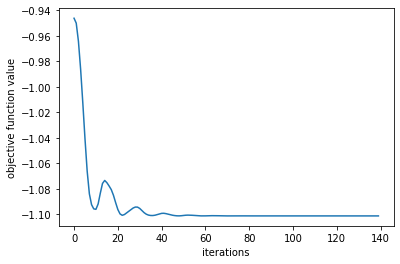

In [65]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(lin_alg_energy,
                   theta_combined_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(150)
GG.plot_convergence()